# Test : Clustering worker_profession

## 1. Lecture et format des données

In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer #tfidf

#librairies pour les graphiques
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.express as px

init_notebook_mode(connected=True)

In [65]:
data = pd.read_csv("worker_profession.csv")

In [66]:
# Affichage aléatoire de 5 éléments de la base
data.sample(5, random_state=42)

worker_id  \
21666  11eaa711-abba-4c62-848f-0574ca29b1e2   
3844   53af50ac-d894-4f98-89d5-95970cdb6f4a   
7932   29df22ff-a24e-405f-9463-81e8cca51eb9   
4702   0834dab8-17c8-4bd1-9928-99fd7fa9be4e   
13351  d510a165-2a4d-4eee-9081-5786525f25a3   

                                        list_professions  
21666  Employé contact clientèle |0;Opérateur de fabr...  
3844   Employé contact clientèle |0;Agent de conditio...  
7932   Agent d'entretien |2;Plongeur |0;Manutentionna...  
4702   Ouvrier d'exécution en milieu difficile |0;Com...  
13351  Préparateur de commandes |21;Ouvrier d'exécuti...

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28448 entries, 0 to 28447
Data columns (total 2 columns):
worker_id           28448 non-null object
list_professions    28444 non-null object
dtypes: object(2)
memory usage: 444.6+ KB


In [68]:
# Check des valeurs manquantes
data.isna().sum()

worker_id           0
list_professions    4
dtype: int64

Nous avons 4 valeurs manquantes. La taille de notre base est de 28448 x 2

In [69]:
# Voyons voir ces individus
data[data.list_professions.isna()]

worker_id list_professions
15417  4da26848-b5df-4f6c-b702-fe58e5d06ab9              NaN
17955  dbfa02f5-9b76-46a7-b39d-563d61ed168e              NaN
21924  05d645f1-5406-49ce-8da7-604940125113              NaN
23431  d7afab4f-b53d-431a-81cc-4e21ba3fabf8              NaN

In [70]:
# Nous supprimons ces 4 individus qui ne nous sont d'aucune utilité pour l'instant
data.dropna(inplace=True)

In [71]:
# Les 4 éléments ont bien été supprimés
data.shape

(28444, 2)

In [72]:
# Pas de répétitions d'ID
data.worker_id.is_unique

True

Voyons la liste de profession de 3 individus au hasard

In [73]:
data.list_professions.sample(3,random_state=24).tolist()

["Auxiliaire de vie sociale |3;Ouvrier d'exécution en milieu difficile |0;Employé de bureau |0;Employé contact clientèle |0;Ouvrier d'exécution polyvalent |0;Agent de service hospitalier |15",
 "Infirmier |4;Ouvrier d'exécution en milieu difficile |0;Ouvrier d'exécution polyvalent |0;Employé de bureau |0;Employé contact clientèle |0",
 "Commis de salle |1;Ouvrier d'exécution polyvalent |0;Employé contact clientèle |0;Ouvrier d'exécution en milieu difficile |0;Employé de bureau |0"]

#### Question : Pourquoi indiquer 0 mois d'expérience ? Ne faudrait-il pas juste supprimer les emplois à 0 mois d'expérience ?

#### Réponse : Nous assumons dans la suite que les individus ayant 0 comme nombre d'expérience n'ont jamais travaillé dans ce domaine.

# Elimner les documents ayant une seule apparition peut etre bien !!

## 2. Analyse des données

In [81]:
def clean_profession(p):
    cleaned_professions = p.split(';')
    for i in range(len(cleaned_professions)):
        cleaned_professions[i]    = cleaned_professions[i].split(' |')
        cleaned_professions[i][0] = cleaned_professions[i][0].replace(' ', '_')
        cleaned_professions[i][1] = int(cleaned_professions[i][1])
    return cleaned_professions

In [91]:
# Nous changeons un peu le format des données
data1 = data.copy()
data1.list_professions = data1.list_professions.apply(clean_profession)
data1 = data1.explode('list_professions')
data1["profession"] = data1.list_professions.apply(lambda r: r[0])
data1["nb_mois_xp"] = data1.list_professions.apply(lambda r: r[1])
data1.drop('list_professions', axis=1, inplace=True)
data1.head()

worker_id                 profession  nb_mois_xp
0  52754c03-3853-485b-8cc2-95c53684675c                Electricien           1
0  52754c03-3853-485b-8cc2-95c53684675c                    Cariste         107
0  52754c03-3853-485b-8cc2-95c53684675c  Employé_contact_clientèle           0
0  52754c03-3853-485b-8cc2-95c53684675c                 Commercial           1
0  52754c03-3853-485b-8cc2-95c53684675c                  Animation          27

### Quelques statistiques

Tout d'abord, nous supprimons les observations dont le nombre d'expériences est nul. Comme nous l'avons dit précédemment, nous assumons dans la suite que les individus ayant 0 comme nombre d'expérience n'ont jamais travaillé dans ce domaine.

In [128]:
# Uniquement 25% de la base à conserver
(data1.nb_mois_xp>0).mean()

0.256668927668496

In [129]:
data1 = data1[data1.nb_mois_xp > 0]

In [130]:
data1.profession.nunique(), data1.worker_id.nunique()

(174, 23923)

Nous avons donc 178 professions distinctes dans la base pour 23 923 individus. Nous remarquons donc qu'il y avait des individus dans la base de données qui n'ont jamais travaillé.

In [131]:
data1.describe()

nb_mois_xp
count  41624.000000
mean      24.030415
std       45.031073
min        1.000000
25%        3.000000
50%        9.000000
75%       24.000000
max     1413.000000

Nous avons une moyenne autour de 24 mois d'expérience (2 ans) et un écart-type de 45. Les quantiles nous montrent une très forte dispersion de cette variable (écart entre le max et le 3ème quartile).

In [132]:
def plot_bar(series, top_N = 10):
    series = series[::-1][-top_N-1:]
    to_plot  = [go.Bar(
                x=series.values,
                y=series.index,
                orientation = 'h'
    )]

    iplot(to_plot)

In [133]:
# Tri des professions selon la somme totale du nombre d'expériences 
data1.groupby('profession').agg(sum).sort_values("nb_mois_xp", ascending=False)

nb_mois_xp
profession                                   
Vendeur                                102998
Préparateur_de_commandes                78300
Commercial                              64821
Cariste                                 61755
Assistant_polyvalent_/_Secrétaire       50663
...                                       ...
Technicien_d'analyse_biomédicale           23
Examinateur                                14
Manipulateur_radio                         12
Employé_contact_clientèle                   3
Sage_femme                                  3

[174 rows x 1 columns]

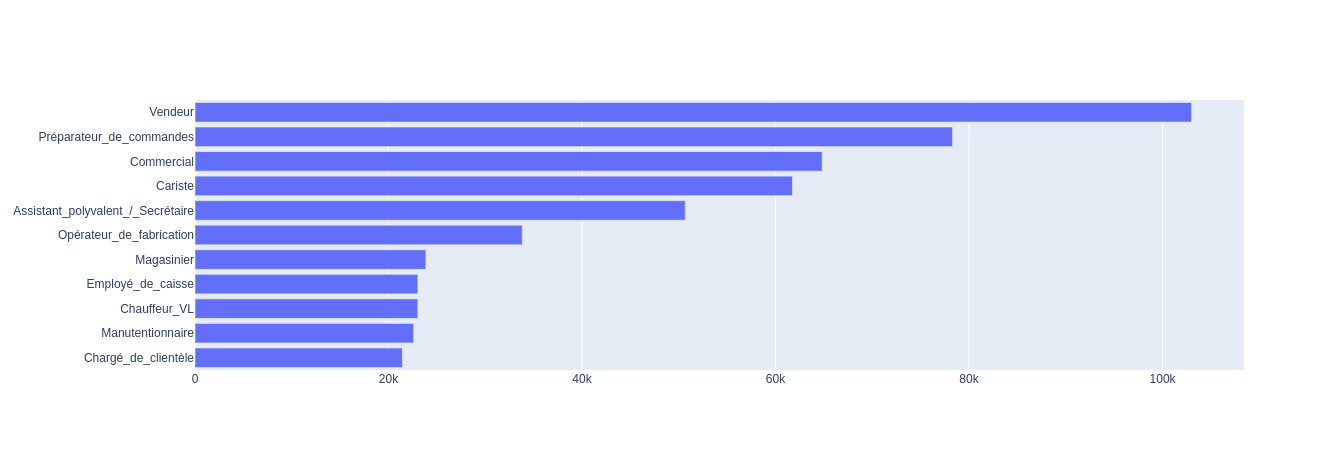

In [134]:
plot_bar(data1.groupby('profession').agg(sum).sort_values("nb_mois_xp", ascending=False).squeeze())

La profession "Vendeur" est la plus pratiquée dans cette base de données en terme somme totale d'expériences cumulée.

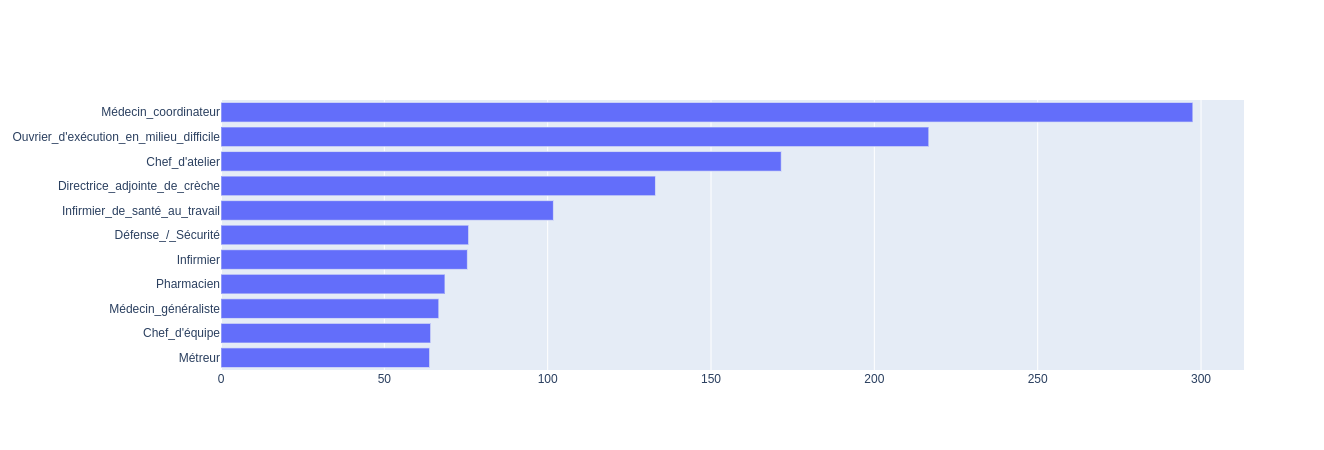

In [135]:
# ET maintenan, en moyenne, ca donne quoi ?
plot_bar(data1.groupby('profession').agg('mean').sort_values("nb_mois_xp", ascending=False).squeeze())

Les individus ont en moyenne plus d'expérience en tant que "Médecin coordinateur".

Nous nous intéressons maintenant aux professions les plus pratiqués par les individus. Il s'agit de trier les professions selon le nombre d'individus ayant déjà travaillé dans ce domaine au moins une fois.

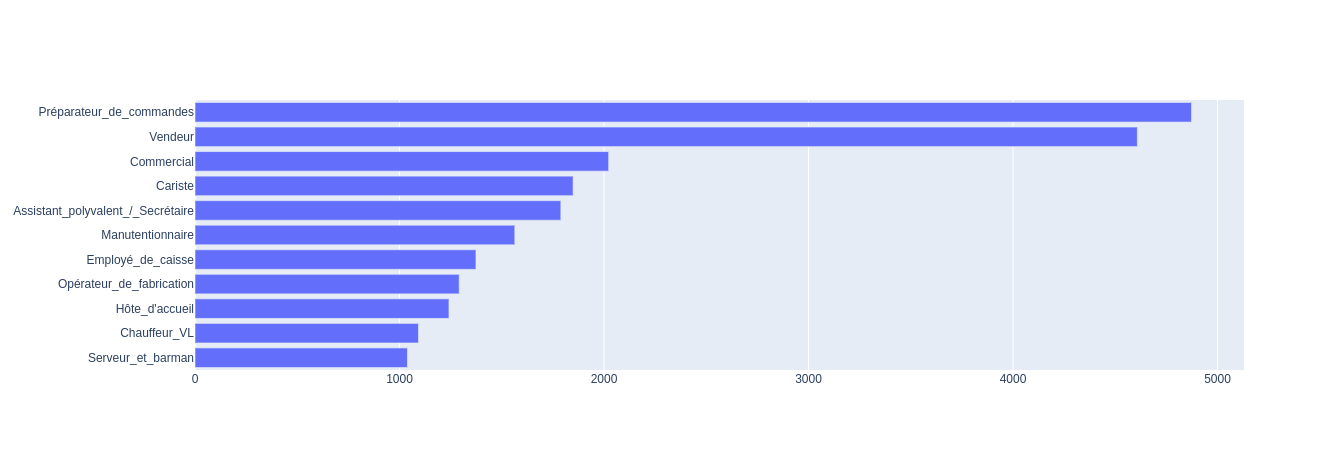

In [137]:
plot_bar(data1.profession.value_counts())

In [141]:
data1[data1.profession == "Préparateur_de_commandes"].nb_mois_xp.mean()

16.068130515083112

On voit donc que beaucoup plus de personnes sont passés par le métier "Préparateur de commande", cependant le temps moyen de travail est assez faible (moyenne de 16 mis).

## 3. Clustering

Dans toute cette partie, nous essayons de mettre en place une technique d'apprentissage non supervisée permettant de regrouper les individus et les professions dans des groupes aussi distinctes que possible. Nous allons utiliser des outils de text mining pour cela.

Nous considérons notre base de données comme un corpus de documents composés de mots, c'est à dire que chaque individu est considéré comme un document dans lequel est écrit l'ensemble des professions qu'il a déjà effectué (séparés par des espaces). Nous tiendrons compte du nombre d'expériences dans des sous-sections séparées afin de marquer la différence. A noter qu'aucun nettoyage des documents n'est nécessaire car chaque document contient uniquement les mots clés nécessaires (les tokens sont déjà prêts pour l'analyse et donc il n'y a plus d'étape de préprocessing du texte). De ce fait, il n'y a nul besoin de faire du stemming, de la lemmatisation ou même d'enlever les stop_words.

Préparation des données

In [161]:
# Attention, l'ordre des worker_id a changé dans cette nouvelle table
data2 = data1.groupby('worker_id').agg({'profession' : lambda r : ' '.join(list(r))}).copy()
data2.head()

profession
worker_id                                                                              
0003e59c-a459-4842-b0ec-67a996c9f2fc                                            Vendeur
00043d14-f02b-4396-98c3-1783eaec6335                                  Employé_de_caisse
00053bba-f458-4d64-aa73-067ccfc88b1e                                            Cariste
00066800-1bea-4685-b475-61a63f0ebbba  Téléprospecteur Assistant_polyvalent_/_Secrétaire
000773d1-62f3-446f-be4b-b7bbc7627a54       Hôtesse Vendeur Artistique Employé_de_caisse

In [165]:
# Echantillon de la base
data2.sample(4, random_state=1)

profession
worker_id                                                                              
cb4b279d-687d-472c-895a-48c057490cd5                                   Manutentionnaire
f339cd52-37d7-4047-83a2-77a63218a6ce  Préparateur_de_commandes Chauffeur_VL Agent_de...
5bf2cfdf-cf51-4c03-bc10-0c493503c925  Vendeur Commercial Opérateur_de_fabrication Pl...
c2dc66ac-cef8-4e8f-a1fa-06f5c71074cd                                            Cariste

Voilà donc à quoi ressemble l'association de chaque document à l'ensemble des tokens retenus pour ce dernier. Nous créons enfin la liste "docs" contenant tous les douments.

In [167]:
docs = data2.profession.tolist()
len(docs)

23923

Nous avons donc, pour rappel, un vocabulaire de 173 mots avec 23 923 individus.

Dans la suite, nous construisons donc une grande matrice sparse de 23 923 x 173 qui contiendra des valeurs non nulles uniquement dans les cellules où l'individu concerné a déjà travaillé dans la profession concernée, plusieurs méthodes sont alors disponibles pour assigner ces valeurs.

### 3.1. Une approche traditionnelle : le K-Means

#### 3.1.1. Une matrice binaire : le CountVectorizer

In [169]:
counter = CountVectorizer(binary=True)

In [170]:
sparse_data = counter.fit_transform(docs)
sparse_data

<23923x193 sparse matrix of type '<class 'numpy.int64'>'
	with 46790 stored elements in Compressed Sparse Row format>

Choisir le nombre de clusters...

In [206]:
def plot_line(x,y):
    fig = go.Figure(data=go.Scatter(x=x, y=y))
    fig.show()

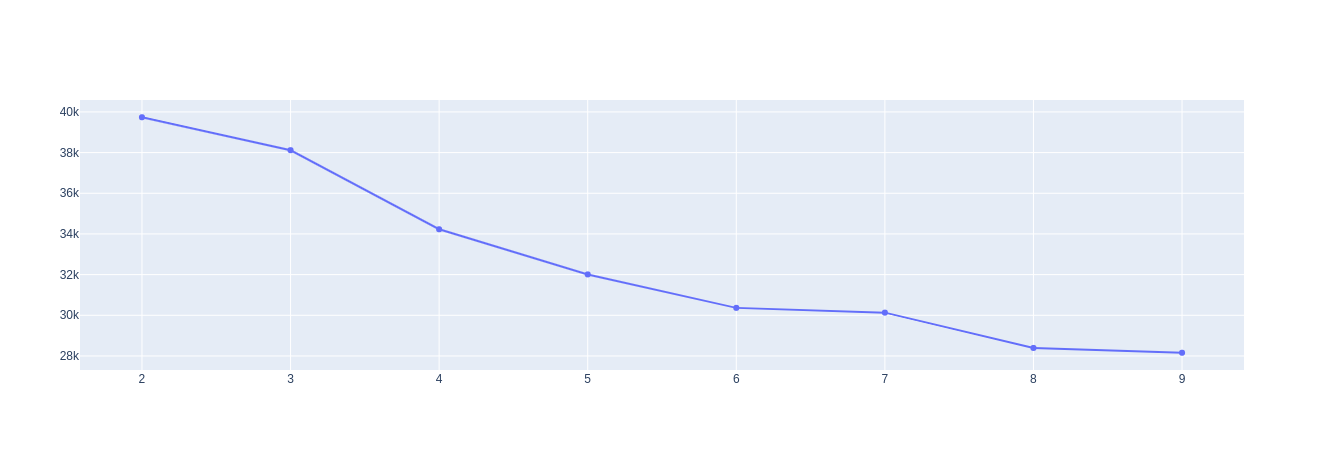

In [209]:
sse = [KMeans(n_clusters=k, random_state=0).fit(sparse_data).inertia_ for k in range(2,10)]
plot_line(np.arange(2,10), sse)

On peut choisir K=6 comme étant le nombre de clusters. On va représenter ces clusters sur les deux primières composantes d'une ACP.

In [220]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(sparse_data)

In [232]:
pca = PCA(n_components=2).fit(sparse_data.toarray())

In [233]:
# Seulement une représentativité de 18%..
pca.explained_variance_ratio_

array([0.10142623, 0.0840201 ])

In [234]:
pca_components = pca.transform(sparse_data.toarray())

In [236]:
cluster_df = pd.DataFrame(pca_components, columns=["C1", "C2"])
cluster_df['cluster'] = kmeans.labels_
cluster_df

C1        C2  cluster
0      0.526299 -0.628448        3
1      0.083943  0.096631        1
2     -0.093042  0.207809        1
3      0.424194  0.883683        0
4      0.622688 -0.678298        3
...         ...       ...      ...
23918 -0.093042  0.207809        1
23919  0.022203  0.167991        1
23920 -0.830888 -0.193545        2
23921  0.009720  0.150058        1
23922  0.008669  0.156072        1

[23923 rows x 3 columns]

In [223]:
fig = px.scatter(cluster_df, x="C1", y="C2", color="cluster")
fig.show()

#### 3.1.2. Le TFIDF

In [238]:
tfidf = TfidfVectorizer()
sparse_data = tfidf.fit_transform(docs)
sparse_data

<23923x193 sparse matrix of type '<class 'numpy.float64'>'
	with 46790 stored elements in Compressed Sparse Row format>

In [240]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(sparse_data)
pca = PCA(n_components=2).fit(sparse_data.toarray())

# Seulement une représentativité de 18%..
pca.explained_variance_ratio_

array([0.10501705, 0.079491  ])

In [241]:
pca_components = pca.transform(sparse_data.toarray())
cluster_df = pd.DataFrame(pca_components, columns=["C1", "C2"])
cluster_df['cluster'] = kmeans.labels_
fig = px.scatter(cluster_df, x="C1", y="C2", color="cluster")
fig.show()

#### 3.1.2. Nombre d'experience comme valeur de la matrice.

In [245]:
from scipy.sparse import csr_matrix

In [249]:
sparse_data = csr_matrix(data1.pivot(index='worker_id', columns='profession', values='nb_mois_xp').fillna(0))
sparse_data.toarray()

array([[0., 0., 0., ..., 0., 7., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Nous voyons bien que la table contient des entiers correspondants au nombre de mois d'expériences.

In [250]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(sparse_data)
pca = PCA(n_components=2).fit(sparse_data.toarray())

# Seulement une représentativité de 16%..
pca.explained_variance_ratio_

array([0.0990185 , 0.06927922])

In [251]:
pca_components = pca.transform(sparse_data.toarray())
cluster_df = pd.DataFrame(pca_components, columns=["C1", "C2"])
cluster_df['cluster'] = kmeans.labels_
fig = px.scatter(cluster_df, x="C1", y="C2", color="cluster")
fig.show()

Les points semblent un peu rassemblés, mais on remarque que les clusters sont un peu plus distincts dans ce cas. Cette information d'expérience semble donc précieuse.

### 3.2. Une nouvelle approche : le Spectral Co-Clustering 

Le Co-Clustering permet à la fois de représenter des groupes (clusters) simultanément en tenant compte des lignes et des colonnes dans la matrice des documents-mots. Elle permet donc une analyse plus complète et donne d'énormes avantages permettant de "tagger" facilement une sous population de notre base. 
Voir exemples très bien détaillés : https://www.researchgate.net/publication/221506581 et http://www.kemaleren.com/post/spectral-biclustering-part-1/

In [308]:
model = SpectralCoclustering(n_clusters=6, svd_method='arpack')
sparse_data = tfidf.fit_transform(docs)
model.fit(sparse_data)

SpectralCoclustering(init='k-means++', mini_batch=False, n_clusters=6,
                     n_init=10, n_jobs=None, n_svd_vecs=None, random_state=None,
                     svd_method='arpack')

In [309]:
model.get_shape(0)

(23868, 188)

In [340]:
fit_data = sparse_data[np.argsort(model.row_labels_)]
fit_data = sparse_data[:, np.argsort(model.column_labels_)]
#plt.figure(figsize=(16,6))
#plt.matshow(fit_data.toarray(), fignum=1, aspect='auto', cmap=plt.cm.Blues)

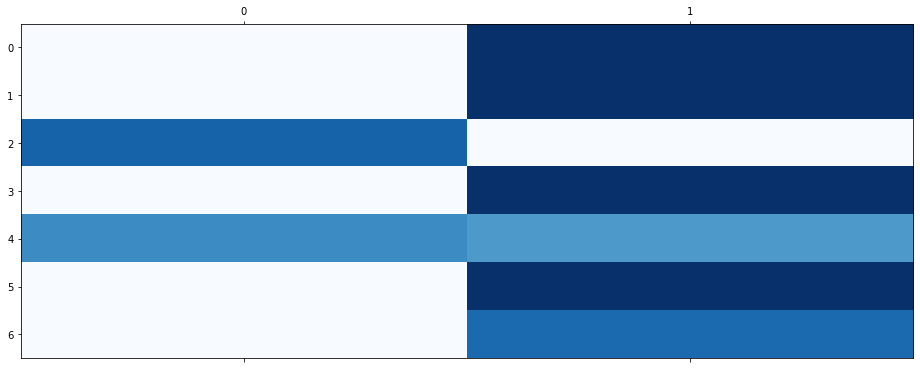

In [339]:
plt.figure(figsize=(16,6))
plt.matshow(model.get_submatrix(4, sparse_data).toarray(), fignum=1, aspect='auto', cmap=plt.cm.Blues)

Nous prenons l'exemple ici du cluster N°4. On voit que chaque ligne représente un individu et chaque colonne une profession. Ce graphique peut etre lu compte un heatmap où chaque cellule représente l'intensité de liaison simultanée entre l'individu et la profession.